In [29]:
import pandas as pd

In [30]:
file_path = "../data/sample_sales_data.xlsx"
df = pd.read_excel(file_path)
df.head()

,product_name,sale_date,quantity_sold
0,GadgetB,2024-07-01,17
1,ThingamajigC,2024-07-01,12
2,DoohickeyD,2024-07-01,3
3,WidgetA,2024-07-02,10
4,GadgetB,2024-07-02,1


In [31]:
print(df.columns)

Index(['product_name', 'sale_date', 'quantity_sold'], dtype='object')


In [32]:
df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')
df = df.sort_values('sale_date')

In [33]:
df_grouped = df.groupby(['product_name', 'sale_date'])['quantity_sold'].sum().reset_index()

In [34]:
all_products = []
for product in df_grouped['product_name'].unique():
    df_product = df_grouped[df_grouped['product_name'] == product].copy()
    date_range = pd.date_range(df_product['sale_date'].min(), df_product['sale_date'].max())
    df_product = df_product.set_index('sale_date').reindex(date_range).fillna({'product_name': product, 'quantity_sold': 0}).reset_index()
    df_product.rename(columns={'index': 'sale_date'}, inplace=True)
    all_products.append(df_product)

df_clean = pd.concat(all_products)

In [35]:
df_clean.to_excel("../data/sales_clean.xlsx", index=False)

In [36]:
import matplotlib.pyplot as plt
import plotly.express as px

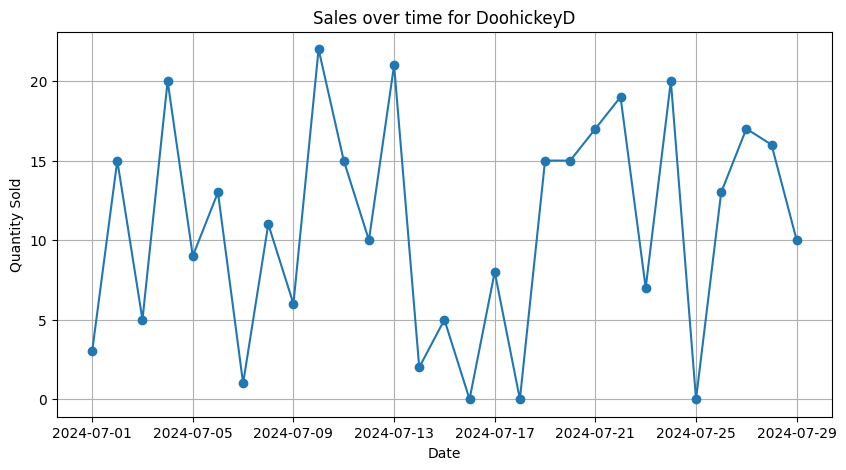

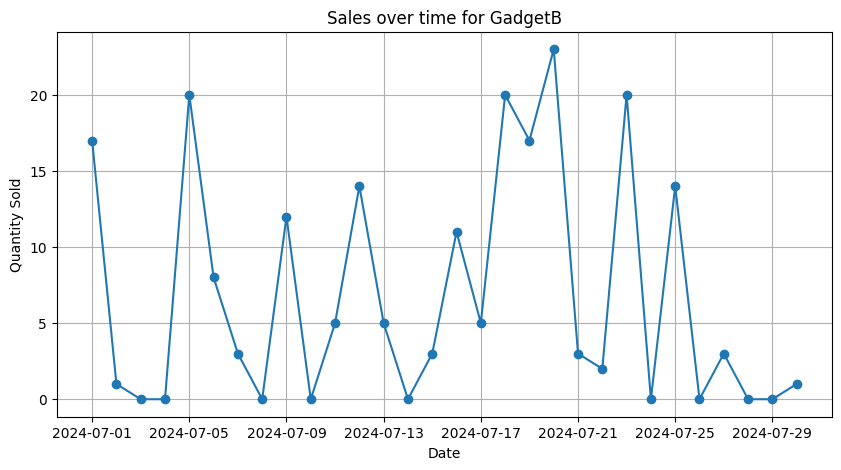

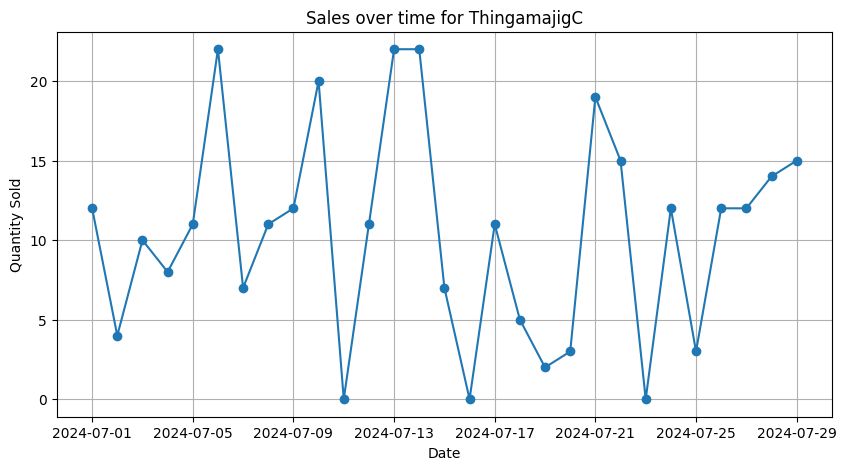

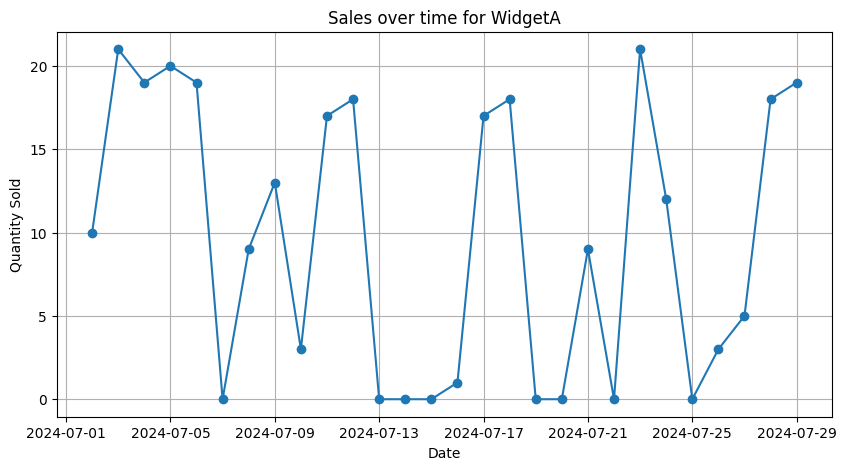

In [37]:
# 6. Plot for each product
for product in df_clean['product_name'].unique():
    df_plot = df_clean[df_clean['product_name'] == product]
    
    # Matplotlib plot
    plt.figure(figsize=(10,5))
    plt.plot(df_plot['sale_date'], df_plot['quantity_sold'], marker='o')
    plt.title(f"Sales over time for {product}")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.grid(True)
    plt.show()

    # Plotly interactive plot
    fig = px.line(df_plot, x='sale_date', y='quantity_sold', title=f"Sales over time for {product}")
    fig.show()

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Fix matplotlib backend and styling issues
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Force matplotlib to use colorful defaults
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'none',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black',
    'axes.labelcolor': 'black'
})

# =======================
# 1. Enhanced Forecasting with Multiple Parameters
# =======================
# df_clean is already available from previous cells

# Create output folder if not exists
os.makedirs("../output_forecasts_enhanced", exist_ok=True)

# Prepare final DataFrame to store all products' forecasts
all_forecasts = []

# Define vibrant color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']

print("🚀 Starting Enhanced Forecasting...")
print("=" * 50)

# Calculate overall product totals for pie chart
overall_product_totals = df_clean.groupby('product_name')['quantity_sold'].sum()

# =======================
# 2. Loop through products with enhanced features
# =======================
for product_idx, product in enumerate(df_clean['product_name'].unique()):
    print(f"📈 Processing {product}...")
    
    df_product = df_clean[df_clean['product_name'] == product].copy()
    df_product = df_product.sort_values("sale_date")

    # =======================
    # Feature Engineering
    # =======================
    
    # 1. Time-based and Seasonality Features
    df_product['day_of_week'] = df_product['sale_date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_product['month'] = df_product['sale_date'].dt.month
    df_product['quarter'] = df_product['sale_date'].dt.quarter
    df_product['day_of_month'] = df_product['sale_date'].dt.day
    df_product['is_weekend'] = df_product['day_of_week'].isin([5, 6]).astype(int)
    df_product['is_month_start'] = (df_product['sale_date'].dt.day <= 5).astype(int)
    df_product['is_month_end'] = (df_product['sale_date'].dt.day >= 25).astype(int)
    df_product['days_from_start'] = (df_product['sale_date'] - df_product['sale_date'].min()).dt.days

    # 2. Lag Features (Previous sales as predictors)
    df_product['sales_lag_1'] = df_product['quantity_sold'].shift(1)  # Yesterday's sales
    df_product['sales_lag_3'] = df_product['quantity_sold'].shift(3)  # 3 days ago
    df_product['sales_lag_7'] = df_product['quantity_sold'].shift(7)  # 1 week ago
    
    # 3. Rolling Statistics (Moving averages and volatility)
    df_product['rolling_mean_3'] = df_product['quantity_sold'].rolling(window=3, min_periods=1).mean()
    df_product['rolling_mean_7'] = df_product['quantity_sold'].rolling(window=7, min_periods=1).mean()
    df_product['rolling_mean_14'] = df_product['quantity_sold'].rolling(window=14, min_periods=1).mean()
    df_product['rolling_std_7'] = df_product['quantity_sold'].rolling(window=7, min_periods=1).std().fillna(0)
    df_product['rolling_max_7'] = df_product['quantity_sold'].rolling(window=7, min_periods=1).max()
    df_product['rolling_min_7'] = df_product['quantity_sold'].rolling(window=7, min_periods=1).min()
    
    # 4. Exponential Smoothing (Multiple alpha values)
    df_product['exp_smooth_02'] = df_product['quantity_sold'].ewm(alpha=0.2).mean()  # Slow adaptation
    df_product['exp_smooth_05'] = df_product['quantity_sold'].ewm(alpha=0.5).mean()  # Medium adaptation
    df_product['exp_smooth_08'] = df_product['quantity_sold'].ewm(alpha=0.8).mean()  # Fast adaptation
    
    # 5. Trend and Momentum Features
    df_product['sales_trend'] = df_product['quantity_sold'].diff().fillna(0)
    df_product['sales_momentum'] = df_product['sales_trend'].rolling(window=3, min_periods=1).mean()
    df_product['sales_acceleration'] = df_product['sales_trend'].diff().fillna(0)
    
    # 6. Cyclical patterns (sine/cosine for seasonality)
    df_product['day_of_week_sin'] = np.sin(2 * np.pi * df_product['day_of_week'] / 7)
    df_product['day_of_week_cos'] = np.cos(2 * np.pi * df_product['day_of_week'] / 7)
    df_product['month_sin'] = np.sin(2 * np.pi * df_product['month'] / 12)
    df_product['month_cos'] = np.cos(2 * np.pi * df_product['month'] / 12)

    # =======================
    # Prepare data for modeling
    # =======================
    
    # Select features for modeling
    feature_cols = [
        'days_from_start', 'day_of_week', 'month', 'quarter', 'day_of_month',
        'is_weekend', 'is_month_start', 'is_month_end',
        'sales_lag_1', 'sales_lag_3', 'sales_lag_7',
        'rolling_mean_3', 'rolling_mean_7', 'rolling_mean_14', 'rolling_std_7',
        'rolling_max_7', 'rolling_min_7',
        'exp_smooth_02', 'exp_smooth_05', 'exp_smooth_08',
        'sales_trend', 'sales_momentum', 'sales_acceleration',
        'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos'
    ]
    
    # Drop rows with NaN values for modeling (due to lag features)
    modeling_data = df_product.dropna()
    
    if len(modeling_data) < 10:  # Need minimum data for enhanced modeling
        print(f"⚠️  Insufficient data for {product}, using simple forecast")
        # Fallback to simple exponential smoothing
        last_exp_smooth = df_product['exp_smooth_05'].iloc[-1]
        future_dates = pd.date_range(start=df_product['sale_date'].max() + pd.Timedelta(days=1), periods=14)
        
        simple_forecast = pd.DataFrame({
            'product_name': product,
            'sale_date': future_dates,
            'quantity_sold_enhanced_forecast': [last_exp_smooth] * len(future_dates)
        })
        
        past_data = df_product[['product_name', 'sale_date', 'quantity_sold']].copy()
        past_data['quantity_sold_enhanced_forecast'] = None
        combined = pd.concat([past_data, simple_forecast], ignore_index=True)
        all_forecasts.append(combined)
        continue

    # =======================
    # Multiple Model Training
    # =======================
    
    X = modeling_data[feature_cols]
    y = modeling_data['quantity_sold']
    
    # 1. Enhanced Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    
    # 2. Random Forest (handles non-linear relationships)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rf_model.fit(X, y)

    # =======================
    # Future Predictions
    # =======================
    
    last_date = df_product['sale_date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14)
    
    # Create future features
    future_predictions = []
    last_row = df_product.iloc[-1].copy()
    
    for i, future_date in enumerate(future_dates):
        # Time-based features for future date
        future_features = {
            'days_from_start': last_row['days_from_start'] + i + 1,
            'day_of_week': future_date.dayofweek,
            'month': future_date.month,
            'quarter': future_date.quarter,
            'day_of_month': future_date.day,
            'is_weekend': int(future_date.dayofweek in [5, 6]),
            'is_month_start': int(future_date.day <= 5),
            'is_month_end': int(future_date.day >= 25),
            'day_of_week_sin': np.sin(2 * np.pi * future_date.dayofweek / 7),
            'day_of_week_cos': np.cos(2 * np.pi * future_date.dayofweek / 7),
            'month_sin': np.sin(2 * np.pi * future_date.month / 12),
            'month_cos': np.cos(2 * np.pi * future_date.month / 12),
        }
        
        # Use previous predictions for lag features
        if i == 0:
            future_features.update({
                'sales_lag_1': last_row['quantity_sold'],
                'sales_lag_3': df_product['quantity_sold'].iloc[-3] if len(df_product) >= 3 else last_row['quantity_sold'],
                'sales_lag_7': df_product['quantity_sold'].iloc[-7] if len(df_product) >= 7 else last_row['quantity_sold'],
            })
        else:
            future_features.update({
                'sales_lag_1': future_predictions[i-1]['prediction'] if i >= 1 else last_row['quantity_sold'],
                'sales_lag_3': future_predictions[i-3]['prediction'] if i >= 3 else last_row['quantity_sold'],
                'sales_lag_7': future_predictions[i-7]['prediction'] if i >= 7 else last_row['quantity_sold'],
            })
        
        # Rolling statistics (using recent values)
        future_features.update({
            'rolling_mean_3': last_row['rolling_mean_3'],
            'rolling_mean_7': last_row['rolling_mean_7'],
            'rolling_mean_14': last_row['rolling_mean_14'],
            'rolling_std_7': last_row['rolling_std_7'],
            'rolling_max_7': last_row['rolling_max_7'],
            'rolling_min_7': last_row['rolling_min_7'],
            'exp_smooth_02': last_row['exp_smooth_02'],
            'exp_smooth_05': last_row['exp_smooth_05'],
            'exp_smooth_08': last_row['exp_smooth_08'],
            'sales_trend': last_row['sales_trend'],
            'sales_momentum': last_row['sales_momentum'],
            'sales_acceleration': last_row['sales_acceleration'],
        })
        
        # Make predictions
        X_future = pd.DataFrame([future_features])[feature_cols]
        
        lr_pred = lr_model.predict(X_future)[0]
        rf_pred = rf_model.predict(X_future)[0]
        
        # Ensemble prediction (weighted average)
        ensemble_pred = 0.3 * lr_pred + 0.7 * rf_pred  # RF gets higher weight
        ensemble_pred = max(0, ensemble_pred)  # No negative sales
        
        future_predictions.append({
            'sale_date': future_date,
            'prediction': ensemble_pred,
            'lr_prediction': max(0, lr_pred),
            'rf_prediction': max(0, rf_pred)
        })

    # =======================
    # Create forecast dataframes
    # =======================
    
    # Enhanced forecast with ensemble method
    future_forecast = pd.DataFrame({
        'product_name': product,
        'sale_date': [pred['sale_date'] for pred in future_predictions],
        'quantity_sold_enhanced_forecast': [pred['prediction'] for pred in future_predictions],
        'quantity_sold_lr_forecast': [pred['lr_prediction'] for pred in future_predictions],
        'quantity_sold_rf_forecast': [pred['rf_prediction'] for pred in future_predictions],
    })

    # Combine with historical data
    past_data = df_product[['product_name', 'sale_date', 'quantity_sold']].copy()
    past_data['quantity_sold_enhanced_forecast'] = None
    past_data['quantity_sold_lr_forecast'] = None
    past_data['quantity_sold_rf_forecast'] = None

    combined = pd.concat([past_data, future_forecast], ignore_index=True)
    all_forecasts.append(combined)

    # =======================
    # Enhanced Colorful Plotting with Pie Charts
    # =======================
    
    # Create a 2x2 subplot layout to include pie charts
    fig = plt.figure(figsize=(18, 14))
    fig.suptitle(f'📈 Complete Sales Analysis for {product}', fontsize=20, fontweight='bold', color='black')
    
    # Top subplot - Sales forecast with vibrant colors
    ax1 = plt.subplot(2, 2, (1, 2))  # Top row spans both columns
    
    # Use bright, distinct colors
    ax1.plot(df_product['sale_date'], df_product['quantity_sold'], 
             label="📊 Historical Sales", marker='o', linewidth=4, markersize=8, 
             color='#1E88E5', markerfacecolor='white', markeredgewidth=2)
    
    ax1.plot(future_forecast['sale_date'], future_forecast['quantity_sold_enhanced_forecast'], 
             label="🚀 Enhanced Ensemble Forecast", linestyle='--', marker='s', linewidth=4, markersize=7,
             color='#FF6B35', markerfacecolor='white', markeredgewidth=2)
    
    ax1.plot(future_forecast['sale_date'], future_forecast['quantity_sold_lr_forecast'], 
             label="📈 Linear Regression", linestyle=':', alpha=0.9, linewidth=3,
             color='#4CAF50')
    
    ax1.plot(future_forecast['sale_date'], future_forecast['quantity_sold_rf_forecast'], 
             label="🌲 Random Forest", linestyle='-.', alpha=0.9, linewidth=3,
             color='#E91E63')
    
    # Highlight weekends with colored backgrounds
    for _, row in future_forecast.iterrows():
        if row['sale_date'].dayofweek in [5, 6]:
            ax1.axvline(x=row['sale_date'], color='#FFB74D', alpha=0.6, linestyle=':', linewidth=3)
    
    # Add a vertical line to separate historical and forecast data
    ax1.axvline(x=df_product['sale_date'].max(), color='#795548', linestyle='-', alpha=0.7, linewidth=3)
    ax1.text(df_product['sale_date'].max(), ax1.get_ylim()[1]*0.9, 'Forecast Start', 
             rotation=90, verticalalignment='top', fontweight='bold', color='black', fontsize=12)
    
    ax1.set_title("Sales Forecast Analysis", fontsize=16, pad=20, color='black', fontweight='bold')
    ax1.set_xlabel("Date", fontsize=14, color='black')
    ax1.set_ylabel("Quantity Sold", fontsize=14, color='black')
    ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=12)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=1, color='gray')
    ax1.tick_params(axis='x', rotation=45, colors='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.set_facecolor('#FAFAFA')
    
    # Bottom left - Feature importance with colorful bars
    ax2 = plt.subplot(2, 2, 3)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(8)
    
    # Create a colorful bar chart with distinct colors
    bar_colors = ['#FF5722', '#FF9800', '#FFC107', '#CDDC39', '#8BC34A', '#4CAF50', '#009688', '#00BCD4']
    bars = ax2.barh(range(len(feature_importance)), feature_importance['importance'], 
                    color=bar_colors[:len(feature_importance)])
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width + 0.002, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold', fontsize=11, color='black')
    
    ax2.set_yticks(range(len(feature_importance)))
    ax2.set_yticklabels(feature_importance['feature'], fontsize=11, color='black')
    ax2.set_title("🔍 Top Feature Importance", fontsize=14, pad=15, color='black', fontweight='bold')
    ax2.set_xlabel("Importance Score", fontsize=12, color='black')
    ax2.grid(True, alpha=0.3, axis='x', color='gray')
    ax2.set_facecolor('#FAFAFA')
    ax2.tick_params(colors='black')
    
    # Bottom right - Pie chart for product contribution
    ax3 = plt.subplot(2, 2, 4)
    
    # Calculate current product's share
    current_product_total = overall_product_totals[product]
    other_products_total = overall_product_totals.sum() - current_product_total
    
    # Create pie chart data
    pie_labels = [f'{product}\n({current_product_total} units)', f'Other Products\n({other_products_total:.0f} units)']
    pie_values = [current_product_total, other_products_total]
    pie_colors = [colors[product_idx % len(colors)], '#E0E0E0']
    
    wedges, texts, autotexts = ax3.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', 
                                       colors=pie_colors, startangle=90, textprops={'fontsize': 11, 'color': 'black'})
    
    # Make the text bold and readable
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    for text in texts:
        text.set_fontweight('bold')
        text.set_color('black')
    
    ax3.set_title(f"🥧 {product}'s Market Share", fontsize=14, pad=15, color='black', fontweight='bold')
    
    # Adjust layout and save with high quality
    plt.tight_layout()
    plt.savefig(f"../output_forecasts_enhanced/{product}_complete_analysis.png", 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.close()
    
    print(f"✅ Enhanced forecast with pie chart completed for {product}")

# =======================
# 3. Save combined results
# =======================
if all_forecasts:
    final_df = pd.concat(all_forecasts, ignore_index=True)
    final_df.to_excel("../output_forecasts_enhanced/all_products_enhanced_forecast.xlsx", index=False)
    
    print("\n" + "="*50)
    print("🎉 Enhanced Forecasting Complete!")
    print("📂 Results saved in 'output_forecasts_enhanced' folder")
    print("📊 Each image now includes:")
    print("   ✓ Colorful line chart with forecasts")
    print("   ✓ Feature importance bar chart")
    print("   ✓ Product market share pie chart")
    print("📋 Features used:")
    print("   ✓ Time-based seasonality (day/week/month patterns)")
    print("   ✓ Lag features (1, 3, 7 days)")
    print("   ✓ Exponential smoothing (multiple alpha values)")
    print("   ✓ Rolling statistics (mean, std, min, max)")
    print("   ✓ Trend and momentum indicators")
    print("   ✓ Cyclical patterns (sine/cosine transformations)")
    print("   ✓ Ensemble modeling (Linear Regression + Random Forest)")
else:
    print("❌ No forecasts generated. Check your data.")

🚀 Starting Enhanced Forecasting...
📈 Processing DoohickeyD...
✅ Enhanced forecast with pie chart completed for DoohickeyD
📈 Processing GadgetB...
✅ Enhanced forecast with pie chart completed for DoohickeyD
📈 Processing GadgetB...
✅ Enhanced forecast with pie chart completed for GadgetB
📈 Processing ThingamajigC...
✅ Enhanced forecast with pie chart completed for GadgetB
📈 Processing ThingamajigC...
✅ Enhanced forecast with pie chart completed for ThingamajigC
📈 Processing WidgetA...
✅ Enhanced forecast with pie chart completed for ThingamajigC
📈 Processing WidgetA...
✅ Enhanced forecast with pie chart completed for WidgetA
✅ Enhanced forecast with pie chart completed for WidgetA


PermissionError: [Errno 13] Permission denied: '../output_forecasts_enhanced/all_products_enhanced_forecast.xlsx'

In [42]:
# 4. Create Interactive Pie Charts for Product Contribution
# =======================
import plotly.graph_objects as go

# Calculate total sales quantity per product
product_totals = df_clean.groupby('product_name')['quantity_sold'].sum()

# Create interactive pie chart for historical sales contribution
fig1 = go.Figure(data=[go.Pie(
    labels=product_totals.index, 
    values=product_totals.values,
    hovertemplate='<b>%{label}</b><br>' +
                  'Quantity: %{value}<br>' +
                  'Percentage: %{percent}<br>' +
                  '<extra></extra>',
    textinfo='label+percent',
    textposition='auto'
)])

fig1.update_layout(
    title="Product Contribution to Total Sales (Historical Data)",
    title_x=0.5,
    font=dict(size=12),
    showlegend=True
)

# Save as HTML for interactivity
fig1.write_html("../output_forecasts/product_contribution_historical.html")
fig1.show()

# Create pie chart with future predictions (using moving average forecast)
future_totals = {}
for product in df_clean['product_name'].unique():
    historical_total = product_totals[product]
    # Get 14-day forecast total from moving average
    df_product = df_clean[df_clean['product_name'] == product].copy()
    window_size = min(7, len(df_product))
    moving_avg = df_product['quantity_sold'].rolling(window=window_size, min_periods=1).mean().iloc[-1]
    if pd.isna(moving_avg):
        moving_avg = df_product['quantity_sold'].mean()
    
    future_14_days = moving_avg * 14  # 14 days of future sales
    future_totals[product] = historical_total + future_14_days

# Create interactive pie chart with forecast
fig2 = go.Figure(data=[go.Pie(
    labels=list(future_totals.keys()), 
    values=list(future_totals.values()),
    hovertemplate='<b>%{label}</b><br>' +
                  'Total Quantity (Historical + Forecast): %{value:.1f}<br>' +
                  'Percentage: %{percent}<br>' +
                  '<extra></extra>',
    textinfo='label+percent',
    textposition='auto'
)])

fig2.update_layout(
    title="Product Contribution to Total Sales (Historical + 14-Day Forecast)",
    title_x=0.5,
    font=dict(size=12),
    showlegend=True
)

# Save as HTML for interactivity
fig2.write_html("../output_forecasts/product_contribution_with_forecast.html")
fig2.show()

# Print the numerical breakdown
print("\n📊 Product Sales Summary:")
print("=" * 50)
print("Historical Sales Quantities:")
for product, total in product_totals.items():
    percentage = (total / product_totals.sum()) * 100
    print(f"{product}: {total:.0f} units ({percentage:.1f}%)")

print("\nWith 14-Day Forecast:")
total_with_forecast = sum(future_totals.values())
for product, total in future_totals.items():
    percentage = (total / total_with_forecast) * 100
    print(f"{product}: {total:.0f} units ({percentage:.1f}%)")


📊 Product Sales Summary:
Historical Sales Quantities:
DoohickeyD: 315 units (28.7%)
GadgetB: 207 units (18.9%)
ThingamajigC: 302 units (27.6%)
WidgetA: 272 units (24.8%)

With 14-Day Forecast:
DoohickeyD: 481 units (30.3%)
GadgetB: 243 units (15.3%)
ThingamajigC: 438 units (27.5%)
WidgetA: 428 units (26.9%)
